In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.optimizers import Adam
from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline


from subprocess import check_output


Using TensorFlow backend.


In [2]:
# set the necessary directories
data_dir = "/home/santanu/Downloads/Carvana/train/"
mask_dir = "/home/santanu/Downloads/Carvana/train_masks/"
all_images = os.listdir(data_dir)


In [3]:
# pick which images we will use for testing and which for validation
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

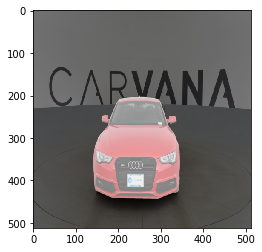

In [4]:
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 4, [512,512])
img, msk = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [5]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [6]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [512,512, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
__________

In [7]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [10]:


#del model
# Training time!
# probably need to play around a little bit with the learning rate to get it to start learning
#num_per_epoch = len(train_images)//
#from keras.models import load_weights
model.load_weights('/home/santanu/model_8_kera.h5')
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
model.fit_generator(train_gen,steps_per_epoch=800, epochs=3)



Epoch 1/3
800/800 [==============================] - 1024s - loss: 0.0083 - dice_coef: 0.9931     

In [9]:
model.save('model_8_kera.h5')

In [11]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

#import ams

input_size = 512
batch_size = 8
orig_width = 1918
orig_height = 1280
threshold=0.5

df_test = pd.read_csv('/home/santanu/Downloads/Carvana/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


rles = []

#odel.load_weights(filepath='weights/best_weights.hdf5')

print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), batch_size))
for start in tqdm(range(0, len(ids_test), batch_size)):
    x_batch = []
    end = min(start + batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch.values:
        img = cv2.imread('/home/santanu/Downloads/Carvana/test/{}.jpg'.format(id))
        img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    ####
    
    
    
    ###
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        rle = run_length_encode(mask)
        rles.append(rle)

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('/home/santanu/Downloads/Carvana/submission_512k_11.csv.gz', index=False, compression='gzip')

  0%|          | 0/12508 [00:00<?, ?it/s]

Predicting on 100064 samples with batch_size = 8...


100%|██████████| 12508/12508 [3:11:34<00:00,  1.09it/s] 


Generating submission file...
